# Investigation of California Socioeconomic Relations Dataset

This contains the chapter on how we cleaned the dataset.

- [Requirements](#library-imports)
- [Mapping the data](#map)

## Importing required libraries<a class="anchor" id="library-imports"></a>

In [3]:
# Standard python packages
import os
import sys

# Other package imports
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from shapely.geometry import shape

## Mapping the Data 

Each individual dataset contains a column for the GEOID and Centroids.csv contains the mapping between each GEOID and lon-lat coordinates.

Centroids was produced using the US Census Block Group Shapefile. Loading this into QGIS software and computing the centroid of each block group polygon with the geometry tools, allowed us to obtain the GEOID-lonlat mapping using the shapefile's corresponding database file.

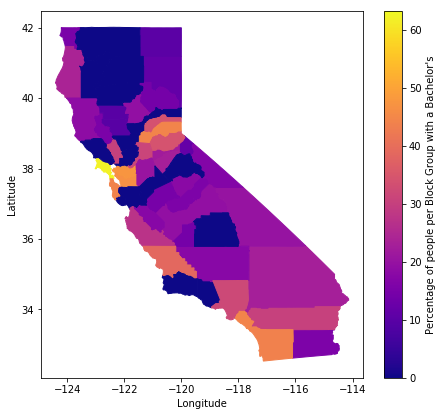

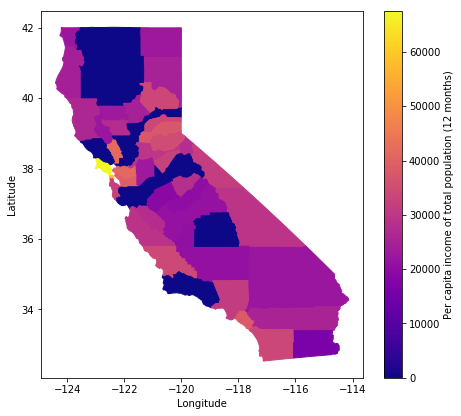

In [7]:
# Condensed data mapping function (refer to Mapping the data for a breakdown)
def mapping_function(CSV_file, CSV_col, cbar_label):
    filename = '../data/interim/Centroids.csv'
    data = np.loadtxt(filename, dtype=str, delimiter=',', usecols=range(10), skiprows=1)
    GEOID = data[:,0]
    LON = data[:,8].astype(float)
    LAT = data[:,9].astype(float)

    filename= '../data/interim/COUNTYNODES.csv'
    data = np.loadtxt(filename, dtype=str, usecols=range(8), skiprows=1, delimiter=',')
    COUNTY = data[:,3]
    CLON = data[:,6].astype(float)
    CLAT = data[:,7].astype(float)

    CSV_file = CSV_file #'../data/processed/X15_EDUCATIONAL_ATTAINMENT.csv'
    CSV_VARIABLE = np.loadtxt(CSV_file, dtype=str, delimiter=',', usecols=(CSV_col,), skiprows=0)
    CSV_VARIABLE_NAME = CSV_VARIABLE[0]
    CSV_VARIABLE = CSV_VARIABLE[1:].astype(float)

    CSV_GEOID = np.loadtxt(CSV_file, dtype=str, delimiter=',', usecols=(2,), skiprows=1)
    CSV_LONLAT = np.zeros((len(CSV_GEOID),2), dtype=float)

    lonlat = np.transpose([LON, LAT])

    # dictionary of mapping:
    D = {}
    for i in range(len(GEOID)):
        D[GEOID[i]] = lonlat[i]

    failed=[] # find index of CSV_GEOID err
    for i in range(len(CSV_GEOID)):
        try:
            CSV_LONLAT[i] = D[CSV_GEOID[i]]
        except:
            #print('FAILED: {}, INDEX: {}'.format(CSV_GEOID[i], i))
            failed.append(i)

    # loop backwards
    for j in range(len(CSV_LONLAT)-1,-1,-1):
        if j in failed:
            CSV_LONLAT = np.delete(CSV_LONLAT, j, axis=0)
            CSV_VARIABLE = np.delete(CSV_VARIABLE, j, axis=0)
    LON = CSV_LONLAT[:,0]
    LAT = CSV_LONLAT[:,1]

    D={}
    lassenlon=[]
    lassenlat=[]
    Dlon = {}
    Dlat = {}
    Dlonlat = {}
    Dpoly = {}

    countynames = []
    for i in COUNTY:
        if i not in countynames:
            countynames.append(i)

    for j in countynames:
        countylon=[]
        countylat=[]
        countylonlat=[]
        for i in range(len(COUNTY)):
            if COUNTY[i] == j: # if COUNTY = countyname
                countylon.append(CLON[i])
                countylat.append(CLAT[i])
                countylonlat.append([CLON[i],CLAT[i]])
        Dlon[j] = countylon
        Dlat[j] = countylat

        # TO PLOT COUNTY BORDERS UNCOMMENT
        #plt.plot(countylon, countylat, c='black', linewidth=0.3)

        Dlonlat[j] = countylonlat
        poly = Polygon(countylonlat)
        Dpoly[j] = poly

    Dvalue = {}
    countycnt=0
    #print(len(LON), len(CSV_VARIABLE))
    # USED TO CALCULATE AVERAGE VALUE OF VARIABLE PER COUNTY:
    for i in countynames:
        countyavg=0
        countycnt=0
        for j in range(len(LON)): # looping through all points in 
            if Dpoly[i].contains(Point(LON[j], LAT[j])):
                countyavg += CSV_VARIABLE[j]
                countycnt += 1
        if countycnt != 0:
            countyavg /= countycnt
            # get percentage assuming 1000 per block group:
            if CSV_file == '../data/processed/X15_EDUCATIONAL_ATTAINMENT.csv':
                countyavg /= 10
        Dvalue[i] = countyavg

    # PLOT POLYGONS
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max(Dvalue.values()))
    #fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,5))
    #ax = fig.add_subplot(111)

    fig = plt.figure(figsize=(8,6))
    ax1  = fig.add_axes([0.10,0.10,0.70,0.85])

    for i in countynames:
        countypoly = Dpoly[i]
        x,y = countypoly.exterior.xy
        cmap = cm.plasma
        color = cmap(norm(Dvalue[i]))

        ax1.fill(x,y, c=color)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.savefig(CSV_VARIABLE_NAME[:30] + ".pdf")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label=cbar_label) #label='Percentage of people per Block Group with a Bachelor\'s')
    plt.show()
    
mapping_function('../data/processed/X15_EDUCATIONAL_ATTAINMENT.csv', 123, 'Percentage of people per Block Group with a Bachelor\'s')
mapping_function('../data/processed/X19_INCOME.csv', 326, 'Per capita income of total population (12 months)')